# Optimization Result Analysis

---

This notebook is used to load optimization results and analyse / visualize them

In [1]:
import pynoisy
import numpy as np
import os
import matplotlib.pyplot as plt
import xarray as xr
from pynoisy.inverse import *

In [20]:
directory = '../runs/GRMHD/02/'
solver = pynoisy.forward.NoisySolver.from_netcdf(os.path.join(directory, 'ccw_rotation_init/final_solver.nc'))
envelope = xr.load_dataarray(os.path.join(directory, 'ccw_rotation_init/final_envelope.nc'))
measurements = xr.load_dataarray(os.path.join(directory,'measurements.nc'))
measurements.name = 'Measurements'

In [25]:
directory = '../runs/full_opt/'
solver = pynoisy.forward.NoisySolver.from_netcdf(os.path.join(directory, 'test1/final_solver.nc'))
envelope = xr.load_dataarray(os.path.join(directory, 'test1/final_envelope.nc'))
true_envelope = xr.load_dataarray(os.path.join(directory, 'true_envelope.nc'))
measurements = xr.load_dataarray(os.path.join(directory,'measurements.nc'))
measurements.name = 'Measurements'

In [38]:
advection = pynoisy.advection.disk(direction='ccw')
diffusion = pynoisy.diffusion.ring(opening_angle=-0.8)
solver = pynoisy.forward.NoisySolver(advection, diffusion)
solver = set_disk_mask(solver)

In [29]:
def compute_gradient(solver, forward, adjoint, dx=1e-2):
    principle_angle = solver.diffusion.principle_angle.copy()
    source = solver.get_laplacian(forward)
    gradient = np.zeros(shape=solver.params.num_unknowns)
    for n, (i, j) in enumerate(zip(*np.where(solver.params.mask))):
        solver.diffusion.principle_angle[i, j] = principle_angle[i, j] + dx
        source_ij = solver.get_laplacian(forward) - source
        solver.diffusion.principle_angle[i, j] = principle_angle[i, j]
        source_ij = source_ij / dx
        gradient[n] += (adjoint * source_ij).mean()
    return gradient
def set_state(solver, state):
    solver.diffusion.principle_angle.values[solver.params.mask] = state
def set_disk_mask(solver):
    solver.params['mask'] = solver.params.r < 0.5 - 2.0 / solver.params.dims['x']
    solver.params.attrs['num_unknowns'] = solver.params.mask.sum().data
    return solver

forward_fn = lambda source: solver.run_symmetric(source, verbose=False)
adjoint_fn = lambda source: solver.run_adjoint(source, verbose=False)
gradient_fn = lambda forward, adjoint: compute_gradient(solver, forward, adjoint)
get_state_fn = lambda: solver.diffusion.principle_angle.values[solver.params.mask]
set_state_fn = lambda state: set_state(solver, state)

krylov_degree = 8
measurements_grf = np.log(
    envelope.where(envelope > 0) /
    measurements.where(measurements > 0)).transpose('t', 'x', 'y', transpose_coords=False).fillna(0.0)
forward_op_grf = ForwardOperator.krylov(
    forward_fn, adjoint_fn, gradient_fn, set_state_fn, get_state_fn, measurements_grf, krylov_degree
)

## Compare measurements

In [15]:
advection = pynoisy.advection.disk()
diffusion = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection, diffusion)
a = solver.run_symmetric()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


In [97]:
directory = '../runs/prior_checks/priniple_angle_init[zero]_krylovdeg[8]_mask[disk]_prior[False]_seed[18177]/'
measurements = xr.load_dataarray(os.path.join(directory,'measurements.nc'))
measurements.name = 'Measurements'

<IPython.core.display.Javascript object>


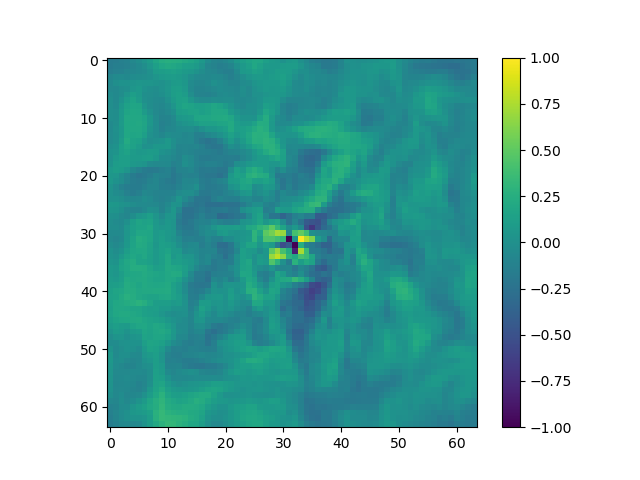

In [105]:
%matplotlib notebook
measurements.noisy_methods.get_animation(vmin=-1, vmax=1, output='MV_meas.gif')

In [94]:
A = np.random.randn(3,3)
A = A_true
f = lambda x: np.matmul(A, x)
y = np.matmul(A_true, n)
k = pynoisy.utils.get_krylov_matrix(y, f, 2)

coefs = np.linalg.lstsq(k.T, y, rcond=None)[0]
rec = np.dot(coefs.T, k)

In [95]:
np.linalg.lstsq(k.T, y, rcond=None)

(array([-0.63935449, -1.19603609]),
 array([0.00048477]),
 2,
 array([2.69187604, 1.98625433]))

<IPython.core.display.Javascript object>


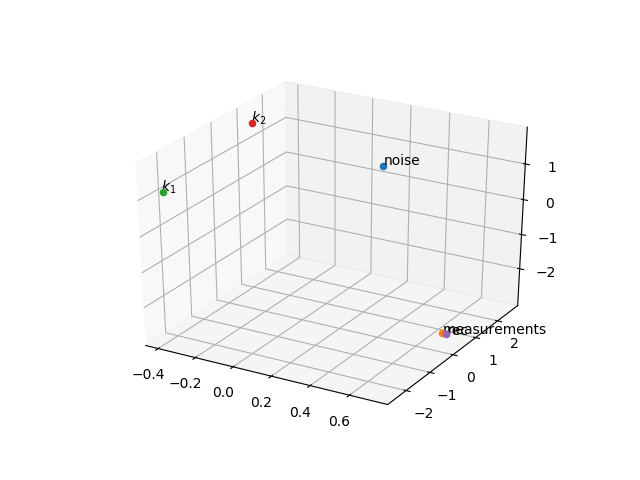

In [96]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

texts = ['noise', 'measurements', r'$k_1$', r'$k_2$', 'rec']
points = [n, y, k[0], k[1], rec]
for i in range(5):
    ax.scatter(*points[i])
    ax.text(*points[i]*1.01, texts[i])

In [32]:
# Generate krylov best fit
krylov_grf = forward_op_grf(forward_op_grf.get_state())
synthetic_measurements = (envelope * np.exp(krylov_grf)).transpose('t', 'x', 'y', transpose_coords=False)
synthetic_measurements.name = 'Synthetic measurements'

In [13]:
# Generate synthetic measurements with the same seed
solver = pynoisy.forward.NoisySolver.from_netcdf(os.path.join(directory, 'test1/final_solver.nc'))
solver.reseed()
diffusion = pynoisy.diffusion.grid(
    solver.diffusion.principle_angle,
    solver.diffusion.correlation_time,
    solver.diffusion.correlation_length,
    solver.diffusion.tensor_ratio
)
solver.update_diffusion(diffusion)
grf = solver.run_symmetric()


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [06:46<00:00, 406.08s/it]


Traceback (most recent call last):
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


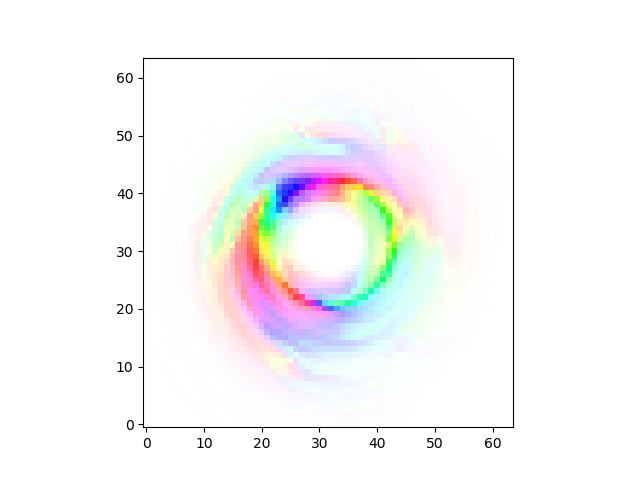

In [22]:
%matplotlib notebook
alphas = Normalize(0, envelope.max(), clip=True)(envelope)
colors = Normalize(0, np.pi)(np.mod(solver.diffusion.principle_angle, np.pi))
cmap = plt.cm.hsv
colors = cmap(colors)
colors[..., -1] = alphas
plt.imshow(colors)
plt.gca().invert_yaxis()

<IPython.core.display.Javascript object>


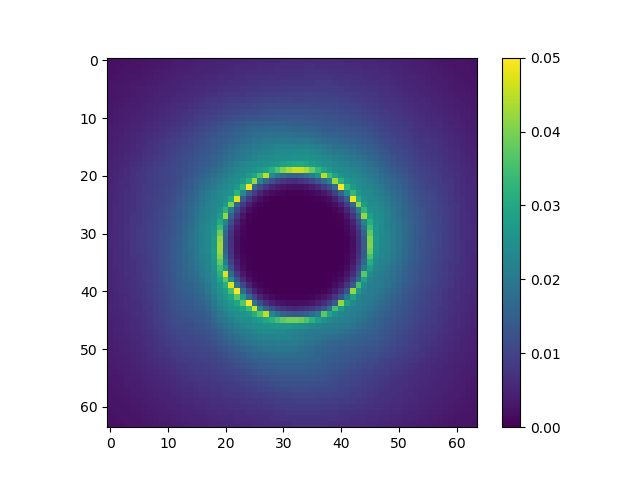

In [19]:
synthetic_measurements = (envelope * np.exp(-10*grf)).transpose('t', 'x', 'y', transpose_coords=False)
synthetic_measurements.name = 'Synthetic measurements'
%matplotlib notebook
synthetic_measurements.noisy_methods.get_animation(vmin=0, vmax=0.05)

<IPython.core.display.Javascript object>


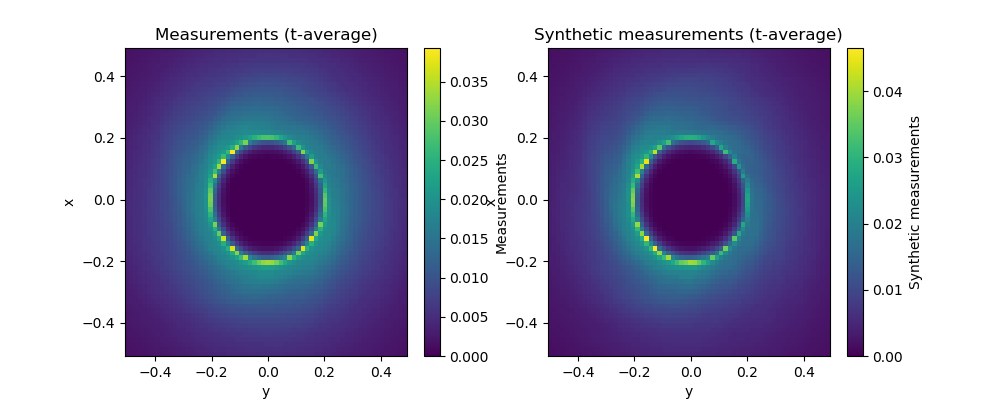

In [7]:
%matplotlib notebook
fig, ax = plt.subplots(1,2, figsize=(10,4))
measurements.mean('t').plot(ax=ax[0])
synthetic_measurements.mean('t').plot(ax=ax[1])
ax[0].set_title('Measurements (t-average)');
ax[1].set_title('Synthetic measurements (t-average)');

<IPython.core.display.Javascript object>


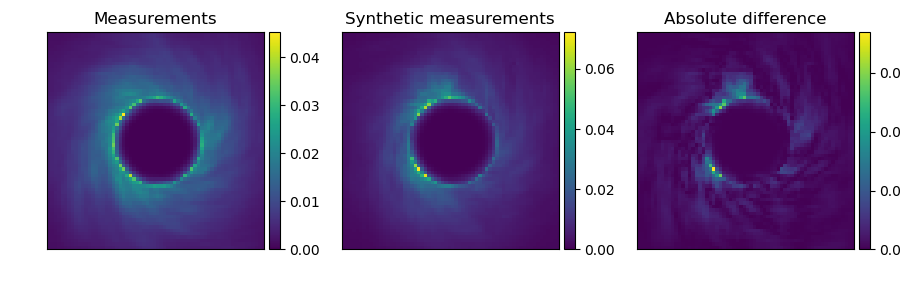

interactive(children=(IntSlider(value=24, description='i', max=49), Output()), _dom_classes=('widget-interact'…

In [8]:
%matplotlib notebook
pynoisy.utils.compare_movie_frames(measurements, synthetic_measurements)

<IPython.core.display.Javascript object>


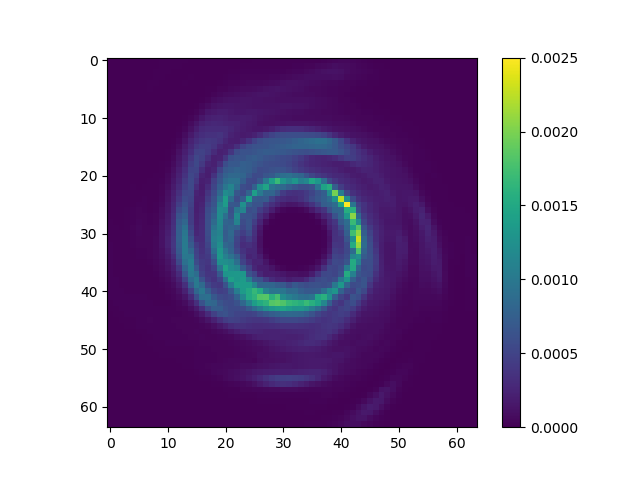

In [12]:
synthetic_measurements.noisy_methods.get_animation(vmin=0, vmax=0.0025, output='grmhd simulations/noisy_krylov.gif')

<IPython.core.display.Javascript object>


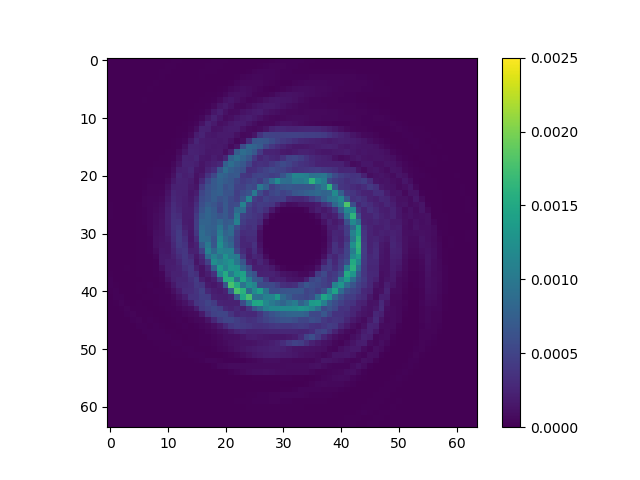

In [15]:
measurements.noisy_methods.get_animation(vmin=0, vmax=0.0025, output='grmhd simulations/grmhd.gif')

In [ ]:
# Generate synthetic measurements with the same seed
grf = f
synthetic_measurements = (envelope * np.exp(grf)).transpose('t', 'x', 'y', transpose_coords=False)
synthetic_measurements.name = 'Synthetic measurements'

<IPython.core.display.Javascript object>


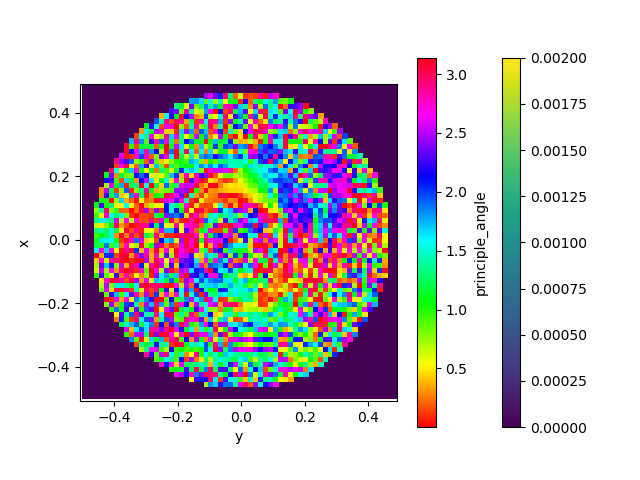

<IPython.core.display.Javascript object>


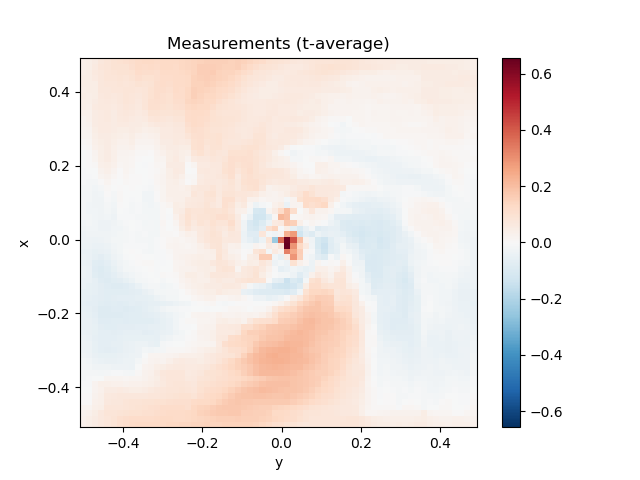

In [213]:
%matplotlib notebook
synthetic_measurements_reseed.mean('t').plot()
plt.title('Measurements (t-average)');

<IPython.core.display.Javascript object>


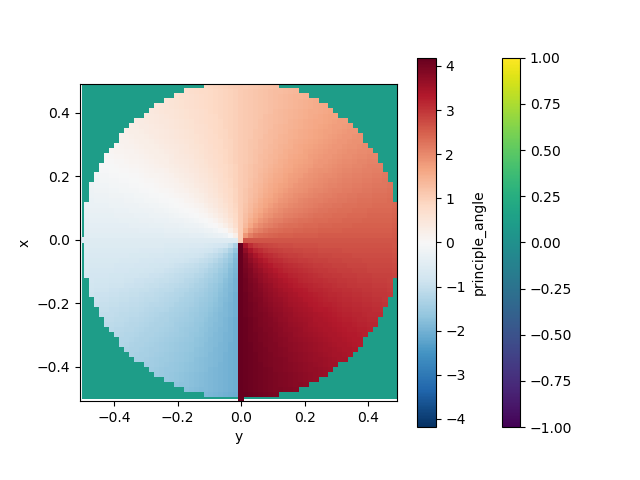

In [107]:
%matplotlib notebook 
synthetic_measurements.noisy_methods.get_animation(vmin=-1.0, vmax=1.0)

## Solver Coeffiecients

<IPython.core.display.Javascript object>


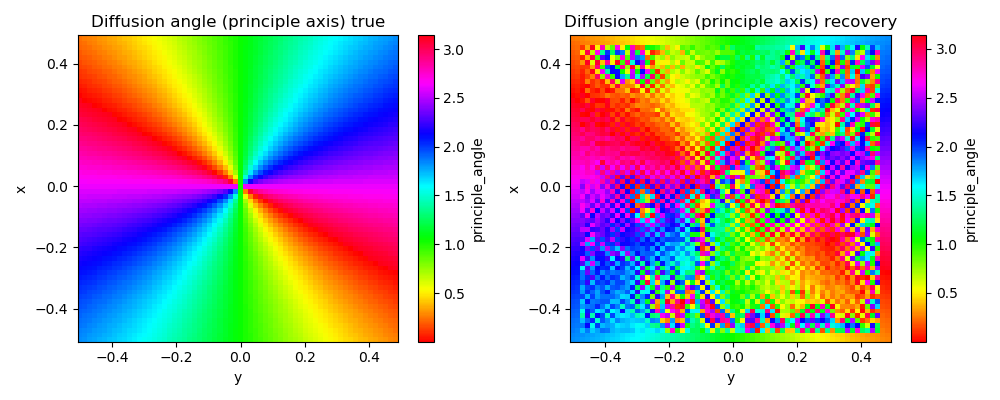

In [219]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
np.mod(pynoisy.diffusion.ring().principle_angle, np.pi).plot(ax=ax[0], cmap='hsv')
np.mod(solver.diffusion.principle_angle, np.pi).plot(ax=ax[1], cmap='hsv')
ax[0].set_title('Diffusion angle (principle axis) true');
ax[1].set_title('Diffusion angle (principle axis) recovery');
plt.tight_layout()